In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import log_loss
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from shutil import copyfile


from torchvision import transforms, models
import torchvision
from PIL import Image
import xml.etree.cElementTree as ET
import os, sys, collections, random
import json, operator
from torch.utils import model_zoo
from sklearn.metrics import average_precision_score, precision_score, accuracy_score

In [2]:
from vocparseclslabels import PascalVOC

#### Dealing with XML File

In [3]:
root='VOCdevkit/VOC2012'
image_dir = os.path.join(root, 'JPEGImages')
annotation_dir = os.path.join(root, 'Annotations')
set_annotation_dir = os.path.join(root, 'ImageSets/Main')
set_annotation_path = os.path.join(set_annotation_dir, 'train'.rstrip('\n') + '.txt')

        

with open(os.path.join(set_annotation_path), "r") as f:
    file_names = [x.strip() for x in f.readlines()]

In [4]:
len(file_names)

5717

In [5]:
images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names] 

In [6]:
list(ET.parse(annotations[0]).getroot())

[<Element 'folder' at 0x1a27fcb1d8>,
 <Element 'filename' at 0x1a27fcb2c8>,
 <Element 'source' at 0x1a27fcb318>,
 <Element 'size' at 0x1a27fcb458>,
 <Element 'segmented' at 0x1a27fcb598>,
 <Element 'object' at 0x1a27fcb5e8>,
 <Element 'object' at 0x1a27fcb908>]

In [7]:
ET.parse(annotations[0]).getroot().text

'\n\t'

In [8]:
ET.parse(annotations[0]).getroot().tag

'annotation'

In [9]:
def parse_xml(node):
    voc_dict = {}
    children = list(node)
    if children:
        def_dic = collections.defaultdict(list)
        for dc in map(parse_xml, children):
            for ind, v in dc.items():
                def_dic[ind].append(v)
        voc_dict = {
            node.tag:
            {ind: v[0] if len(v) == 1 else v
             for ind, v in def_dic.items()}
        }
    if node.text:
        text = node.text.strip()
        if not children:
            voc_dict[node.tag] = text
    return voc_dict

In [10]:
parse_xml(ET.parse(annotations[0]).getroot())

{'annotation': {'folder': 'VOC2012',
  'filename': '2008_000008.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '500', 'height': '442', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'horse',
    'pose': 'Left',
    'truncated': '0',
    'occluded': '1',
    'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
    'difficult': '0'},
   {'name': 'person',
    'pose': 'Unspecified',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
    'difficult': '0'}]}}

In [17]:
class ImgDataset(Dataset):
    def __init__(self, root, transform, dataset='train'):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.dataset = dataset
        self.load()

    def list_image_sets(self):
        """
        Summary: 
            List all the image sets from Pascal VOC. Don't bother computing
            this on the fly, just remember it. It's faster.
        """
        return {'aeroplane':0 , 'bicycle':1, 'bird':2, 'boat':3, 'bottle':4,
              'bus':5, 'car':6, 'cat':7, 'chair':8, 'cow':9, 'diningtable':10,
              'dog':11, 'horse':12, 'motorbike':13, 'person':14, 'pottedplant':15,
              'sheep':16, 'sofa':17, 'train':18, 'tvmonitor':19}
        
    def load(self):
        image_dir = os.path.join(self.root, 'JPEGImages')
        annotation_dir = os.path.join(self.root, 'Annotations')

        if not os.path.isdir(self.root):
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You need to download it')

        set_annotation_dir = os.path.join(self.root, 'ImageSets/Main')
        set_annotation_path = os.path.join(set_annotation_dir, self.dataset.rstrip('\n') + '.txt')

        if not os.path.exists(set_annotation_path):
            raise ValueError(
                'Wrong dataset entered! Please use dataset="train" '
                'or dataset="trainval" or dataset="val" or a valid'
                'dataset from the VOC ImageSets/Main folder.')

        with open(os.path.join(set_annotation_path), "r") as f:
            file_names = [x.strip() for x in f.readlines()]

        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names]        
        
        
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        target = self.parse_xml(ET.parse(self.annotations[index]).getroot())

        ind_list = target['annotation']['object']
        label = []
        if (type(ind_list) is dict):
            label.append(self.list_image_sets()[ind_list['name']])
        else:
            for e in ind_list:
                label.append(self.list_image_sets()[e['name']])
            
        img = self.transform(img)
        return img, to_binary(label), self.images[index]

    def __len__(self):
        return len(self.images)

    def parse_xml(self, node):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            voc_dict = {
                node.tag:
                {ind: v[0] if len(v) == 1 else v
                 for ind, v in def_dic.items()}
            }
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

In [12]:
def to_binary(label_list):
    labels = torch.zeros(20)
    for key in label_list:
        labels[key] = 1
    return labels

In [13]:
torch.full([2, 5], 0.999)

tensor([[0.9990, 0.9990, 0.9990, 0.9990, 0.9990],
        [0.9990, 0.9990, 0.9990, 0.9990, 0.9990]])

In [14]:
target = torch.ones([10, 64], dtype=torch.float32)  # 64 classes, batch size = 10
output = torch.full([10, 64], 0.999)  
pos_weight = torch.ones([64])
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion(output, target)

tensor(0.3135)

In [15]:
def train(model, device, optimizer, train_loader, criterion):
    model.train()

    loss = []
    for idx, data in enumerate(train_loader):
        img, target, name = data
        print(name)
        img, target = img.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(img)
        batch_loss = criterion(output, target)
        print(batch_loss.item())
        batch_loss.backward()
        optimizer.step()
        loss.append(batch_loss.item())

    avg_train_loss = sum(loss)/len(loss)
    print("training loss of batch: ", loss)
    return avg_train_loss

In [16]:
def val(model, device, val_loader, criterion, thres):
    model.eval()

    loss = []
    outputs = []
    predictions = []
    targets = []

    with torch.no_grad():
        for idx, data in enumerate(val_loader):
            img, target, name = data
            targets.append(target)
            img, target = img.to(device), target.to(device)
            prediction = model(img)
            batch_loss = criterion(prediction, target)
            loss.append(batch_loss)
            output = sigmoid(prediction)
            filtered_output = (output > thres)
            outputs.append(output)
            predictions.append(filtered_output)
            
    avg_val_loss = sum(loss)/len(loss)
    output_f = torch.cat(outputs, 0).cpu().detach().numpy().reshape(-1, 20)
    targets_f = torch.cat(targets,0).cpu().detach().numpy().reshape(-1, 20)
    predictions_f = torch.cat(predictions,0).cpu().detach().numpy().reshape(-1, 20)
    avg_precision = average_precision_score(targets_f, predictions_f)

    # get precision score for every class
    precisions = class_wise_precision(predictions_f, targets_f)
    return avg_val_loss, avg_precision, precisions

In [49]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 20)
model.to('cpu')
model.eval()

transform_with_crops = transforms.Compose([transforms.RandomResizedCrop(224),
                               transforms.RandomRotation(20),
                               transforms.ToTensor(),
                               ])

val_set = ImgDataset('./VOCdevkit/VOC2012', transform_with_crops, dataset='val')
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

outputs = []
labels = []
filenames = []

container = iter(val_loader)
temp = next(container)
temp
output = model(img)
outputs.append(output)
labels.append(label)
filenames+=name
print(name)

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

ValueError: too many values to unpack (expected 2)

In [24]:
a = np.array([[1,2,3,4,5,6],[7,8,9,1,2,3],[4,5,6,7,8,9]])
a

array([[1, 2, 3, 4, 5, 6],
       [7, 8, 9, 1, 2, 3],
       [4, 5, 6, 7, 8, 9]])

In [25]:
a[:,0]

array([1, 7, 4])

In [26]:
a[:][0]

array([1, 2, 3, 4, 5, 6])

In [27]:
np.mean(a, 0)

array([4., 5., 6., 4., 5., 6.])

In [28]:
np.mean(a)

5.0

In [29]:
np.array([('a','b'),('c','d'),('e','f')])

array([['a', 'b'],
       ['c', 'd'],
       ['e', 'f']], dtype='<U1')

In [30]:
np.array([('a','b'),('c','d'),('e','f')]).reshape(-1)

array(['a', 'b', 'c', 'd', 'e', 'f'], dtype='<U1')

In [42]:
b = np.random.rand(100,20)
c = np.random.rand(100,20)
pred = (b > 0.5).astype(int)
target = (c > 0.5).astype(int)
np.average([average_precision_score(target[:,i], b[:,i]) for i in range(20)])

0.5145043334555998

In [43]:
average_precision_score(target, b)

0.5145043334555998

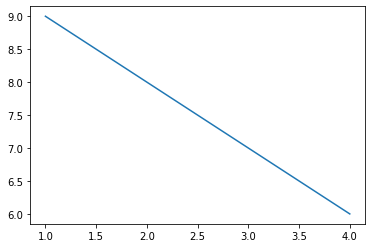

In [45]:
plt.plot(range(1,5), [9,8,7,6])

In [54]:
np.linspace(0.1, 0.9, 9, endpoint=True)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [55]:
pred

array([[1, 1, 1, ..., 1, 0, 1],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 1, 0]])

In [56]:
target

array([[1, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [0, 1, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [1, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 1, 1, 0]])

In [58]:
precision_score(target, pred, average='micro')

0.5087538619979403

In [59]:
pred = (b > 0.5)
precision_score(target, pred, average='micro')

0.5087538619979403

In [63]:
z = torch.ones(3,4)
y = torch.ones(3,4)

In [64]:
z == y

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])

In [65]:
(z == y).all()

tensor(True)

In [66]:
y[0,0] = 0
print(z == y)
(z == y).all()

tensor([[False,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]])


tensor(False)

In [67]:
torch.random(2,3)

TypeError: 'module' object is not callable